## Machine Learning Clustering example notebook

Uses a kaggle dataset with bank transactions 

In [1]:
import numpy as np
import pandas as pd

In [2]:
raw_data = pd.read_csv('data\\bank_transactions_data_2.csv')
raw_data.head()

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,2024-11-04 08:08:08
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,2024-11-04 08:09:35
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,19,Student,56,1,1122.35,2024-11-04 08:07:04
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26,Student,25,1,8569.06,2024-11-04 08:09:06
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,26,Student,198,1,7429.40,2024-11-04 08:06:39


In [3]:
raw_data.info()
raw_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            2512 non-null   object 
 1   AccountID                2512 non-null   object 
 2   TransactionAmount        2512 non-null   float64
 3   TransactionDate          2512 non-null   object 
 4   TransactionType          2512 non-null   object 
 5   Location                 2512 non-null   object 
 6   DeviceID                 2512 non-null   object 
 7   IP Address               2512 non-null   object 
 8   MerchantID               2512 non-null   object 
 9   Channel                  2512 non-null   object 
 10  CustomerAge              2512 non-null   int64  
 11  CustomerOccupation       2512 non-null   object 
 12  TransactionDuration      2512 non-null   int64  
 13  LoginAttempts            2512 non-null   int64  
 14  AccountBalance          

,TransactionAmount,CustomerAge,TransactionDuration,LoginAttempts,AccountBalance
count,2512.000000,2512.000000,2512.000000,2512.000000,2512.000000
mean,297.593778,44.673965,119.643312,1.124602,5114.302966
std,291.946243,17.792198,69.963757,0.602662,3900.942499
min,0.260000,18.000000,10.000000,1.000000,101.250000
25%,81.885000,27.000000,63.000000,1.000000,1504.370000
50%,211.140000,45.000000,112.500000,1.000000,4735.510000
75%,414.527500,59.000000,161.000000,1.000000,7678.820000
max,1919.110000,80.000000,300.000000,5.000000,14977.990000


In [4]:
numeric_cols = ['TransactionAmount', 'CustomerAge', 'TransactionDuration', 'LoginAttempts', 'AccountBalance']

In [5]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [6]:
scaler = StandardScaler()
numeric_scaled = pd.DataFrame(scaler.fit_transform(raw_data[numeric_cols]), columns=numeric_cols)

In [29]:
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(numeric_scaled)
raw_data['KMeans_Cluster'] = kmeans_labels

C:\Users\patri\anaconda3\envs\lg311\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(


<Axes: xlabel='TransactionAmount', ylabel='AccountBalance'>

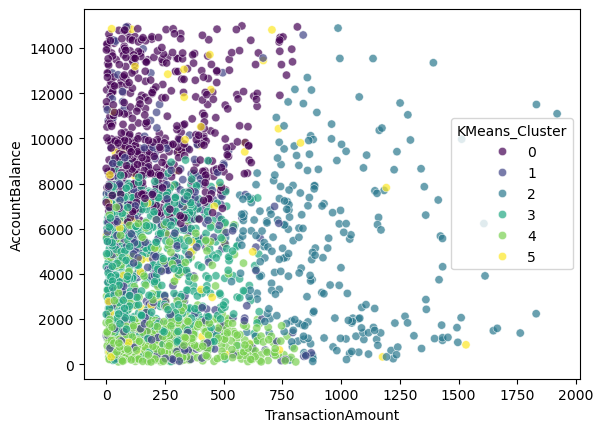

In [30]:
import seaborn as sns
sns.scatterplot(
    x=raw_data['TransactionAmount'],
    y=raw_data['AccountBalance'],
    hue=raw_data['KMeans_Cluster'],
    palette='viridis',
    alpha=0.7,
    legend='full'
)

In [31]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
metrics.silhouette_score(numeric_scaled, kmeans_labels, metric='euclidean')

0.2624845436472968

In [32]:
metrics.calinski_harabasz_score(numeric_scaled, kmeans_labels)

776.0779680134522

In [33]:
centroids = kmeans.cluster_centers_
distances = np.linalg.norm(numeric_scaled.values - centroids[kmeans_labels], axis=1)
raw_data['KMeans_Distance'] = distances

In [34]:
threshold = distances.mean() + 3 * distances.std()
raw_data['KMeans_Fraud'] = distances > threshold

In [35]:
raw_data['KMeans_Fraud'].value_counts()

KMeans_Fraud
False    2480
True       32
Name: count, dtype: int64

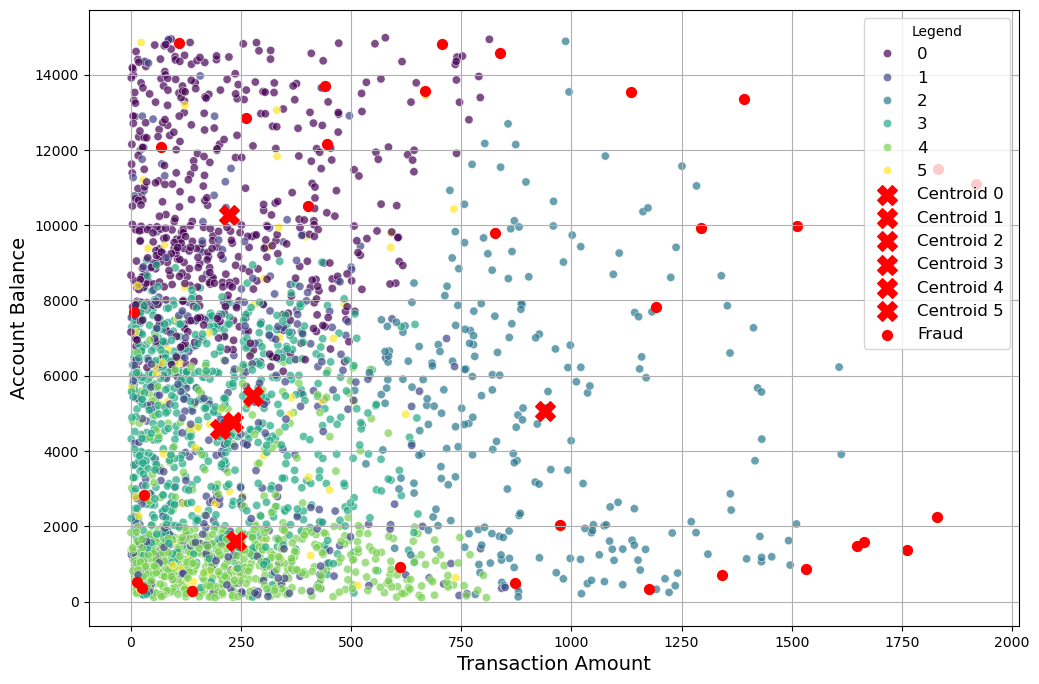

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

sns.scatterplot(
    x=raw_data['TransactionAmount'],
    y=raw_data['AccountBalance'],
    hue=raw_data['KMeans_Cluster'],
    palette='viridis',
    alpha=0.7,
    legend='full'
)

centroids_original = scaler.inverse_transform(centroids)

for i, centroid in enumerate(centroids_original):
    plt.scatter(
        centroid[numeric_cols.index('TransactionAmount')],
        centroid[numeric_cols.index('AccountBalance')],
        color='red',
        marker='X',
        s=200,
        label=f'Centroid {i}'
    )

fraud_points = raw_data[raw_data['KMeans_Fraud']]
plt.scatter(
    fraud_points['TransactionAmount'],
    fraud_points['AccountBalance'],
    color='red',
    marker='o',
    s=50,
    label='Fraud'
)

plt.xlabel('Transaction Amount', fontsize=14)
plt.ylabel('Account Balance', fontsize=14)
plt.legend(title='Legend', fontsize=12)
plt.grid(True)